In [5]:
!pip install pandas pandasql
!pip install prince



  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=8fb04598d98a4a25209908c959435f1ce844400ec3b1484cc52f6d11bfe20e6c
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


In [126]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
import prince
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Part EDA

In [ ]:
## Data Import and Manipulation
info_style_numeric = pd.read_csv("ittf_player_info_style_numeric.csv")
print(info_style_numeric.columns)
# Clean the "Name" column by removing all non-alphabetic characters
info_style_numeric['Name'] = info_style_numeric['Name'].str.replace(r'[^a-zA-Z\s-]', '', regex=True)
# Transform the df into a dict, of which the value is a list containing the numeric values of four styles
styles_dict = info_style_numeric.set_index('Name')[['Playing_hand_numeric', 'Playing_style_numeric', 'Grip_numeric', 'Style_commonness','Assoc']].apply(lambda row: row.tolist(), axis=1).to_dict()
ranking_not_aggregated = pd.read_csv("ittf_ranking_50.csv")
# Apply styles_dict to all cases of all columns of the ranking_50 df.
# The result is a tuple of the player name and a list of style infos.
# For those players who are not in the styles_dict, the value is 99.
ranking_styles = ranking_not_aggregated.map(lambda x: (x, styles_dict.get(x, 99)))
# Rename column "Unnamed: 0" to "ranking"
ranking_styles = ranking_styles.rename(columns={"Unnamed: 0": "Ranking"})
# Replace tuples in the "ranking" column with their first element (to avoid adding 99 to this column)
ranking_styles['Ranking'] = ranking_styles['Ranking'].apply(lambda x: x[0] if isinstance(x, tuple) else x)
# Apply cleaning only to columns *other than* 'Ranking'
ranking_not_aggregated.loc[:, ranking_not_aggregated.columns != 'Ranking'] = (
    ranking_not_aggregated.loc[:, ranking_not_aggregated.columns != 'Ranking']
    .applymap(lambda x: re.sub(r'[^a-zA-Z\s-]', '', x) if isinstance(x, str) else x)
)
# Display result
print(ranking_styles.head())

Index(['Player ID', 'Name', 'Assoc', 'Gender', 'Birth year', 'Activity',
       'Playing hand', 'Playing style', 'Grip', 'Playing_hand_numeric',
       'Playing_style_numeric', 'Grip_numeric', 'Style_commonness'],
      dtype='object')
  Ranking                                    2001  \
0  Rank 1         (WANG Liqin, [0, 0, 0, 0, CHN])   
1  Rank 2  (SAMSONOV Vladimir, [0, 0, 0, 0, BLR])   
2  Rank 3             (MA Lin, [0, 0, 1, 1, CHN])   
3  Rank 4       (LIU Guozheng, [0, 0, 0, 0, CHN])   
4  Rank 5       (KONG Linghui, [0, 0, 0, 0, CHN])   

                                   2002  \
0           (MA Lin, [0, 0, 1, 1, CHN])   
1        (BOLL Timo, [1, 0, 0, 1, GER])   
2       (WANG Liqin, [0, 0, 0, 0, CHN])   
3  (SCHLAGER Werner, [0, 0, 0, 0, AUT])   
4     (KONG Linghui, [0, 0, 0, 0, CHN])   

                                     2003                               2004  \
0             (MA Lin, [0, 0, 1, 1, CHN])      (WANG Hao, [0, 0, 1, 1, CHN])   
1         (WANG Liqin, [0,

/var/folders/9p/6j8bfv1n36l90czq1nymvg780000gn/T/ipykernel_82358/1790396259.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: re.sub(r'[^a-zA-Z\s-]', '', x) if isinstance(x, str) else x)


In [ ]:
allcountry={}
for col in ranking_styles.columns[1:]:
    countrys_this_year=ranking_styles[col].apply(lambda x:x[-1][-1] if isinstance(x[-1],list) else None)
    country_counts=countrys_this_year.value_counts()
    allcountry[col]=country_counts
print(allcountry)

{'2001': 2001
CHN    7
KOR    4
FRA    4
TPE    2
GER    2
AUT    2
NED    2
SWE    2
GRE    1
BLR    1
BEL    1
CRO    1
CZE    1
HKG    1
ESP    1
DEN    1
Name: count, dtype: int64, '2002': 2002
CHN    9
FRA    3
KOR    3
SWE    3
NED    2
GER    2
AUT    2
TPE    2
HKG    2
BEL    1
GRE    1
BLR    1
CRO    1
DEN    1
RUS    1
CZE    1
Name: count, dtype: int64, '2003': 2003
CHN    10
KOR     4
SWE     3
HKG     3
TPE     2
FRA     2
NED     2
AUT     2
GER     2
BEL     1
RUS     1
BLR     1
GRE     1
DEN     1
CZE     1
CRO     1
ROU     1
Name: count, dtype: int64, '2004': 2004
CHN    9
KOR    4
GER    3
AUT    3
SWE    3
TPE    2
RUS    2
FRA    2
HKG    2
BLR    1
DEN    1
BEL    1
GRE    1
NED    1
CZE    1
CRO    1
ROU    1
SRB    1
Name: count, dtype: int64, '2005': 2005
CHN    8
GER    4
KOR    4
SWE    3
FRA    2
TPE    2
CRO    2
AUT    2
NED    2
HKG    2
BLR    1
BEL    1
RUS    1
DEN    1
GRE    1
ROU    1
SGP    1
CZE    1
SRB    1
ESP    1
Name: count, dtype: int64,

['CHN', 'KOR', 'GER', 'JPN', 'SWE', 'AUT', 'HKG', 'TPE', 'FRA', 'CRO']


<Axes: xlabel='year', ylabel='count'>

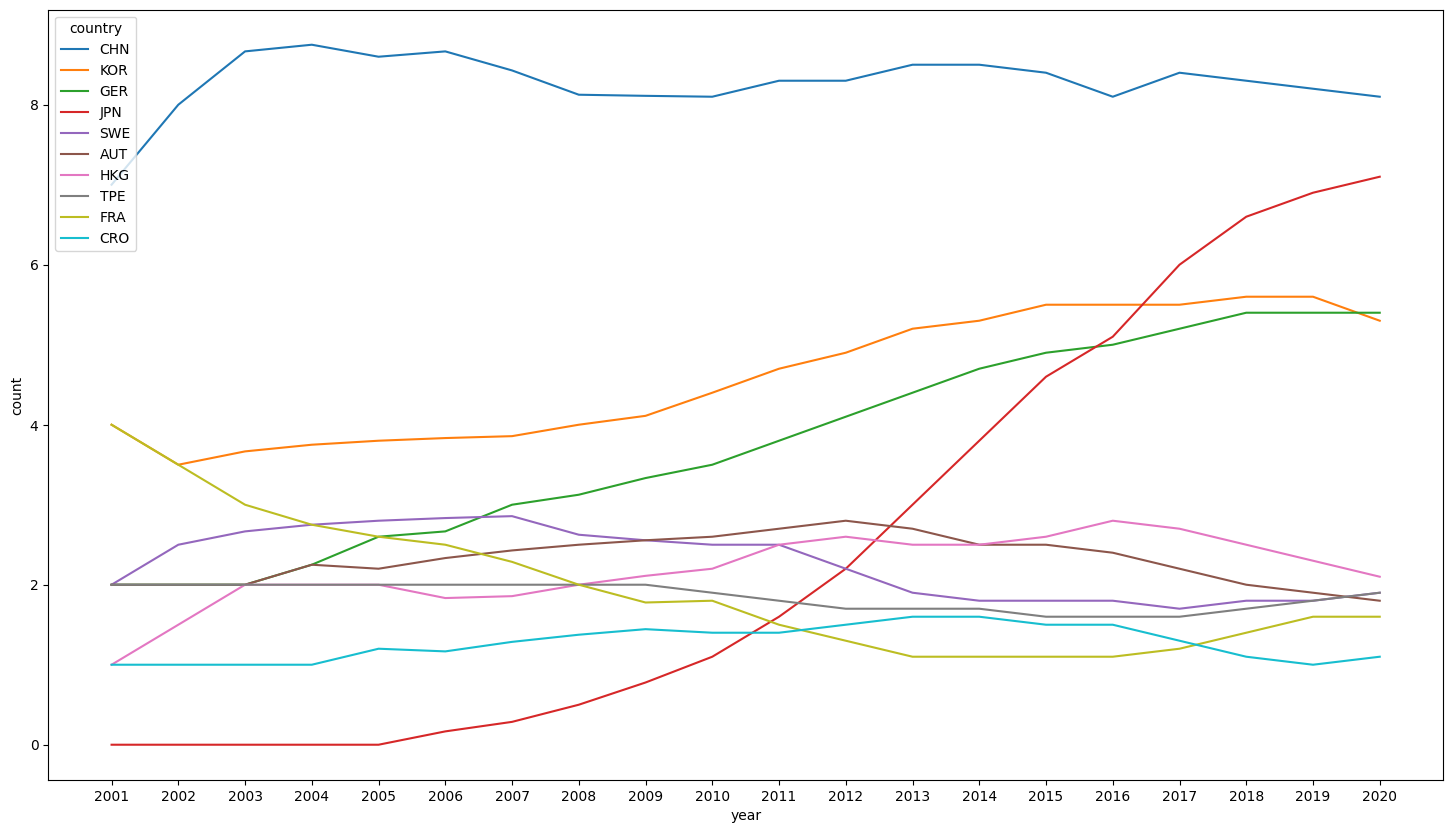

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,10))
df_country_year = pd.DataFrame(allcountry).fillna(0).astype(int).T
country_top10=df_country_year.sum().sort_values(ascending=False).head(10).index.to_list()
print(country_top10)
df_top10=df_country_year[country_top10]
# 假设你还在用 df_top10
df_top10_smooth = df_top10.rolling(window=10, min_periods=1).mean()
df_top10_smooth['year'] = df_top10_smooth.index
df_melted_smooth = df_top10_smooth.melt(id_vars='year',var_name='country', value_name='count')

# 再画图
sns.lineplot(data=df_melted_smooth, x='year',y='count',hue='country')


In [ ]:
## First Round of Ratio Calculation and Visualization (Without Applying Varied Weights)

# The function "extract_and_count" is used to extract the numeric value of each of the four styles from the tuple in each cell
# before counting unique values in the df.
def extract_and_count(dataframe, list_index):
    extracted_values = dataframe.drop(columns=["Ranking"]).map(
        lambda x: x[1][list_index] if isinstance(x[1], list) else x[1]
    )
    return extracted_values.apply(pd.Series.value_counts)

# Applying the function to extract different indices
playinghand_numeric_value = extract_and_count(ranking_styles, 0)
playingstyle_numeric_value = extract_and_count(ranking_styles, 1)
grip_numeric_value = extract_and_count(ranking_styles, 2)
stylecommonness_numeric_value = extract_and_count(ranking_styles, 3)
#print(ranking_styles['2001'])
# Display the results
print("Playing Hand Numeric Value:\n", playinghand_numeric_value)
print("Playing Style Numeric Value:\n", playingstyle_numeric_value)
print("Grip Numeric Value:\n", grip_numeric_value)
print("Style Commonness Numeric Value:\n", stylecommonness_numeric_value)


Playing Hand Numeric Value:
     2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  \
0     21    25    26    29    27    29    29    30    32    34    34    32   
1     12    10    12    10    14    13    14    13    13    12    14    16   
99    17    15    12    11     9     8     7     7     5     4     2     2   

    2013  2014  2015  2016  2017  2018  2019  2020  
0     34    34    37    35  36.0  34.0  33.0  35.0  
1     15    15    12    14  14.0  16.0  17.0  15.0  
99     1     1     1     1   NaN   NaN   NaN   NaN  
Playing Style Numeric Value:
     2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  \
0     28    31    34    36    39    40    41    40    42    43    45    45   
1      5     4     4     3     2     2     2     3     3     3     3     3   
99    17    15    12    11     9     8     7     7     5     4     2     2   

    2013  2014  2015  2016  2017  2018  2019  2020  
0     46    46    46    47  48.0  48.0  47.0  47.0

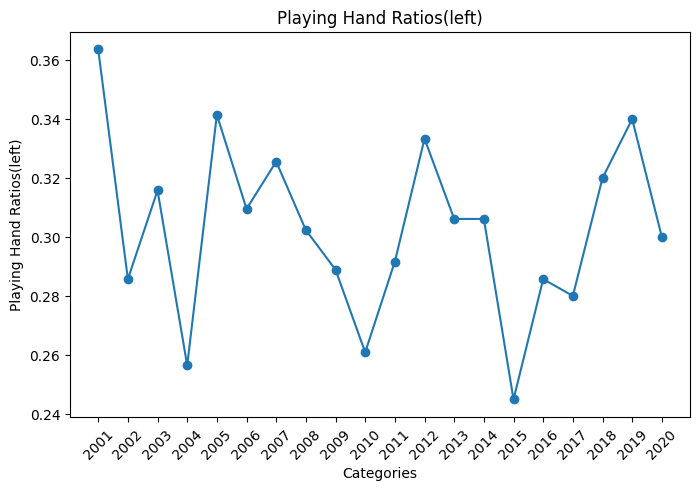

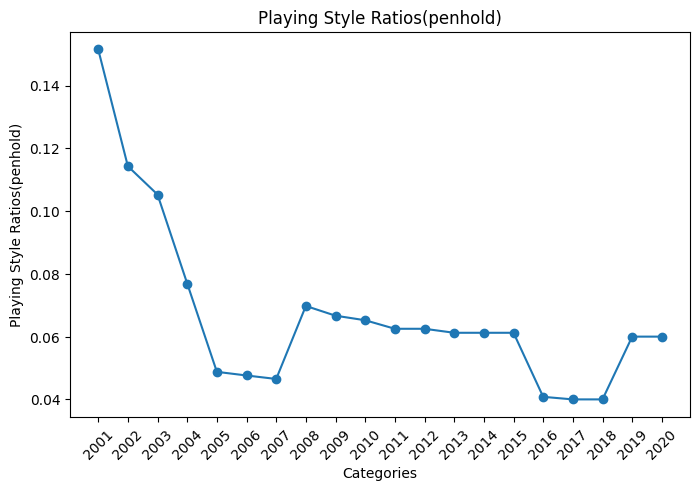

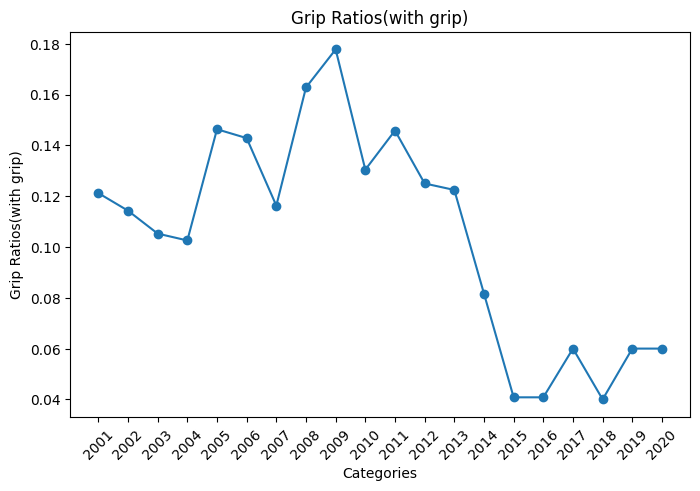

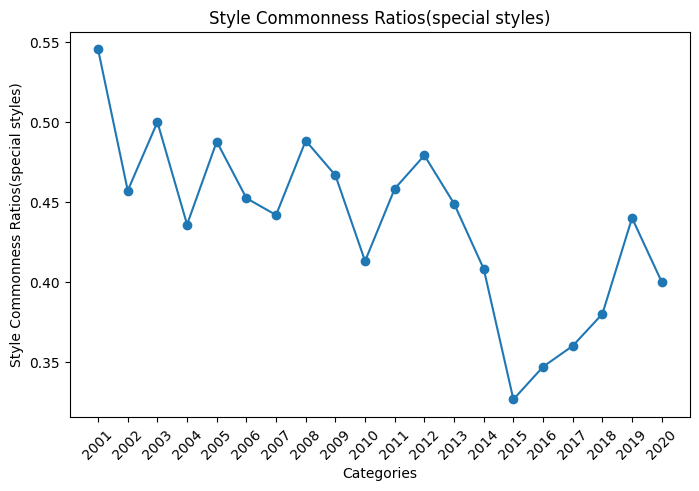

In [ ]:
def calculate_and_visualize_ratios(dataframe, title):

    # Step 1: Compute Ratios
    ratios = {}
    for column in dataframe.columns:
        ratio = dataframe[column][1] / (dataframe[column][1] + dataframe[column][0])
        #print((dataframe[column][1] + dataframe[column][0]))
        ratios[column] = ratio

    # Step 2: Convert dictionary to two separate lists
    x = list(ratios.keys())  # Categories (e.g., Years)
    y = list(ratios.values())  # Corresponding Ratios

    # Step 3: Create the Line Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o')  # Adding markers to highlight data points

    # Add labels and title
    plt.xlabel('Categories')  # Generalized since it can be years, styles, etc.
    plt.ylabel(title)  # Dynamic y-label based on input title
    plt.title(title)

    # Ensure all categories are displayed on the x-axis
    plt.xticks(x, rotation=45)

    # Display the plot
    plt.show()


list_to_plot = [playinghand_numeric_value, playingstyle_numeric_value, grip_numeric_value, stylecommonness_numeric_value]
calculate_and_visualize_ratios(list_to_plot[0], "Playing Hand Ratios(left)")
calculate_and_visualize_ratios(list_to_plot[1], "Playing Style Ratios(penhold)")
calculate_and_visualize_ratios(list_to_plot[2], "Grip Ratios(with grip)")
calculate_and_visualize_ratios(list_to_plot[3], "Style Commonness Ratios(special styles)")



In [ ]:
## Applying Varied Weights to Players of Different Rankings

# Sample data (assuming ranking_styles is already defined)
data = ranking_styles.copy()  # Create a copy to modify without altering the original

# Define the weight function
def compute_weight(index, max_index):
    # if index<=10:
    #     return 0.1
    # else:
    #     return 1
    return 1
    #return 2 - (index / max_index)

# Calculate the maximum index
max_index = len(data) - 1

# Create a new DataFrame to store the weighted values
weighted_df = data.copy()

# Iterate over each year (column) in the DataFrame
for year in data.columns:
    # Iterate over each player's ranking (row index) and value
    for idx, value in enumerate(data[year]):
        # Apply weight only if the value is a tuple and contains a list
        if isinstance(value, tuple) and isinstance(value[1], list):
            weight = compute_weight(idx, max_index)
            # Multiply the entire list by the weight
            modified_tuple = (value[0], [(element+1) * weight for element in value[1]])
            weighted_df.at[idx, year] = modified_tuple  # Store the modified tuple

# Display DataFrame in Jupyter Notebook or VS Code (if using interactive mode)
from IPython.display import display
#display(weighted_df)  # Show DataFrame directly in the output

# Export the wieghted DataFrame to a CSV file
weighted_df.to_csv("styles_weighted_by_rankings.csv", index=False)


In [ ]:
## Calculating the Weighted Ratios to See the Evolution of Styles

# Sample DataFrame (Assuming ranking_styles exists)
data = ranking_styles.copy()  # Create a copy to modify without altering the original

# Initialize dictionaries to store the sum and count for each component (0,1,2,3)
component_sums = {i: {} for i in range(4)}  # Store total sums for four components
component_counts = {i: {} for i in range(4)}  # Store valid row counts for each component

# Iterate over each column (year)
for column in data.columns:
    # Initialize total sum and valid count for each component
    total_sums = [0] * 4  # [Sum for list[0], Sum for list[1], Sum for list[2], Sum for list[3]]
    valid_counts = [0] * 4  # Count valid rows that contain a list as second element

    # Iterate over each cell in the column
    for value in data[column]:
        if isinstance(value, tuple) and len(value) > 1 and isinstance(value[1], list):
            for i in range(min(4, len(value[1]))):  # Ensure we do not exceed list length
                total_sums[i] += value[1][i]  # Sum up values for each list element
                valid_counts[i] += 1  # Count how many valid entries exist

    # Store the results for each component
    for i in range(4):
        component_sums[i][column] = total_sums[i] / valid_counts[i] if valid_counts[i] > 0 else 0

# Convert results to a single DataFrame
styles_evolution_weighted_df = pd.DataFrame({
    "Year": list(component_sums[0].keys()),
    "Playing_Hand_Ratio": list(component_sums[0].values()),
    "Playing_Style_Ratio": list(component_sums[1].values()),
    "Grip_Ratio": list(component_sums[2].values()),
    "Style_Commonness_Ratio": list(component_sums[3].values()),
}).set_index("Year")

# Remove the "Ranking" row from styles_evolution_weighted_df
styles_evolution_weighted_df = styles_evolution_weighted_df.drop("Ranking", errors="ignore")

# Esport the final DataFrame to a CSV file
styles_evolution_weighted_df.to_csv("styles_evolution_weighted.csv")

# Display the final DataFrame
styles_evolution_weighted_df.head()


,Playing_Hand_Ratio,Playing_Style_Ratio,Grip_Ratio,Style_Commonness_Ratio
Year,,,,
2001,0.363636,0.151515,0.121212,0.545455
2002,0.285714,0.114286,0.114286,0.457143
2003,0.315789,0.105263,0.105263,0.500000
2004,0.256410,0.076923,0.102564,0.435897
2005,0.341463,0.048780,0.146341,0.487805


Coefficients: [0.79987041 0.75213615 0.75038113]
Intercept: 0.06543059268475471


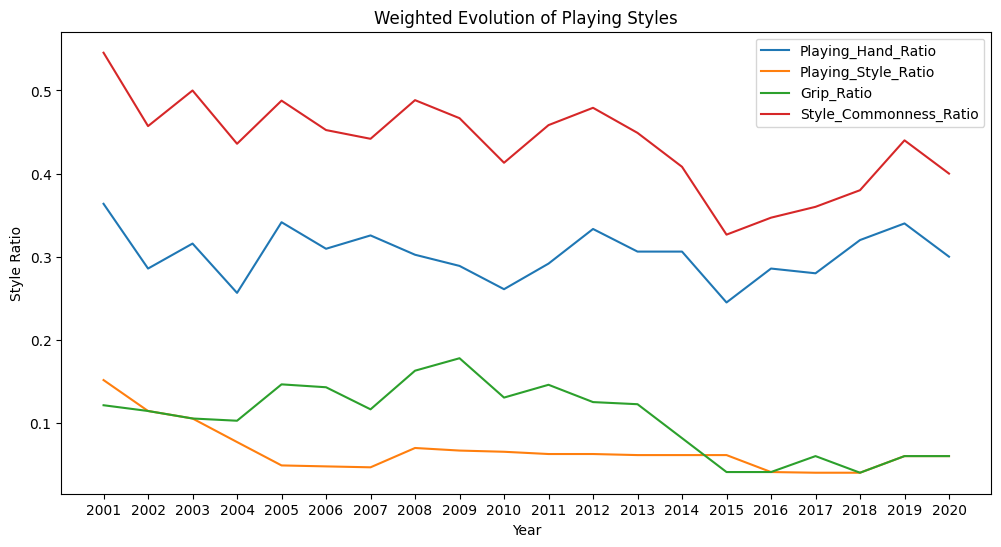

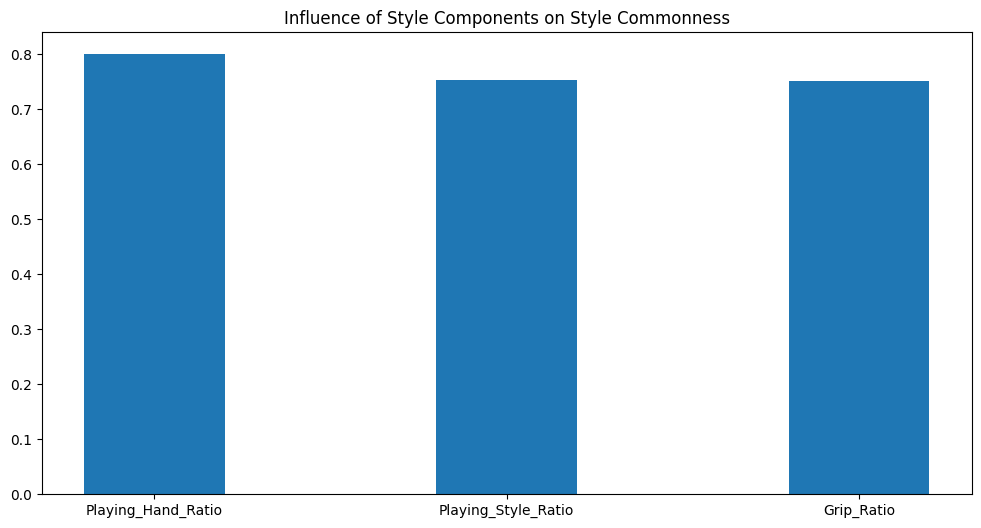

In [ ]:
# Generate a line plot for each component style ratio as well as the commonness ratio

# Define the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each style component
for column in styles_evolution_weighted_df.columns:
    ax.plot(styles_evolution_weighted_df.index, styles_evolution_weighted_df[column], label=column)

# Set the title and labels
ax.set_title("Weighted Evolution of Playing Styles")
ax.set_xlabel("Year")
ax.set_ylabel("Style Ratio")

# Set the legend
ax.legend()




## Influence of Each Dimensions to the Evolution of the Style Commonness (Multiple Linear Regression)

x1 = styles_evolution_weighted_df['Playing_Hand_Ratio']
x2 = styles_evolution_weighted_df['Playing_Style_Ratio']
x3 = styles_evolution_weighted_df['Grip_Ratio']
X = [x1, x2, x3]
X_T = np.transpose(X)
y = styles_evolution_weighted_df['Style_Commonness_Ratio']

# Initialize and train the model
model = LinearRegression()
# Fit the model
model.fit(X_T, y)

# Display the coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


# Visualization

# Define the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.4

# Plot the influence of each component
ax.bar(styles_evolution_weighted_df.columns[:3], model.coef_[:3], width=bar_width)

# Set the title and labels
ax.set_title("Influence of Style Components on Style Commonness")

# Display the plot
plt.show()

In [ ]:
ranking_not_aggregated = pd.read_csv("ittf_ranking_50.csv")
info_style_numeric = pd.read_csv("ittf_player_info_style_numeric.csv")
info_style_numeric.head()

,Player ID,Name,Assoc,Gender,Birth year,Activity,Playing hand,Playing style,Grip,Playing_hand_numeric,Playing_style_numeric,Grip_numeric,Style_commonness
0,145778,AALTONEN Gabriela,SWE,Female,2009.0,Active,Right-handed,Attacker,Shakehand,0,0,0,0
1,110737,AARAS Pal,NOR,Male,1992.0,Inactive,Right-handed,Attacker,Shakehand,0,0,0,0
2,145022,AARRAD Wahiba,MAR,Female,2003.0,Active,Right-handed,Attacker,Shakehand,0,0,0,0
3,116168,AASEBO Anna,NOR,Female,1995.0,Active,Right-handed,Attacker,Shakehand,0,0,0,0
4,110761,AASEBO Marte,NOR,Female,1990.0,Active,Right-handed,Attacker,Shakehand,0,0,0,0


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

def scrape_ittf_win_rates(output_csv="ittf_win_rates_full.csv"):
    # 1. 配置无头 Chrome
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome(options=options)

    # 2. 打开页面并等待首屏加载
    url = "https://results.ittf.link/index.php/statistics/win-rate-senior-events/list/88"
    driver.get(url)
    wait = WebDriverWait(driver, 10)
    time.sleep(2)

    all_data = []
    page = 1

    while True:
        print(f"📄 正在爬第 {page} 页…")
        # 等待表格行渲染
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "table tbody tr")))
        time.sleep(1)

        # 3. 提取本页数据（跳过列数不足的行）
        rows = driver.find_elements(By.CSS_SELECTOR, "table tbody tr")
        page_data = []
        for row in rows:
            cols = row.find_elements(By.TAG_NAME, "td")
            if len(cols) < 6:
                continue
            name    = cols[0].text.strip()      # Name
            winrate = cols[4].text.strip().rstrip('%')  # Win Rate % 在第5列 :contentReference[oaicite:1]{index=1}
            page_data.append((name, winrate))

        # 如果本页一条有效都没，说明已过末页
        if not page_data:
            print("⚠️ 本页无有效数据，结束爬取")
            break
        all_data.extend(page_data)

        # 4. 翻页：先拿到 <a>，再到父 <li> 判断 disabled
        try:
            next_a = driver.find_element(By.LINK_TEXT, "Next")
            next_li = next_a.find_element(By.XPATH, "./..")
            if "disabled" in next_li.get_attribute("class"):
                print("✅ 已到最后一页")
                break

            # 滚动到按钮可视再点击
            driver.execute_script("arguments[0].scrollIntoView({block:'center'});", next_a)
            time.sleep(0.3)
            try:
                next_a.click()
            except ElementClickInterceptedException:
                # JS 强制点击
                driver.execute_script("arguments[0].click();", next_a)

        except (NoSuchElementException, TimeoutException) as e:
            print("⚠️ 找不到 Next 按钮，结束爬取。原因：", e)
            break

        page += 1
        time.sleep(2)

    driver.quit()

    # 5. 保存 CSV
    df = pd.DataFrame(all_data, columns=["Player", "Win Rate"])
    df.to_csv(output_csv, index=False, encoding='utf-8-sig')
    print(f"✅ 全部爬取完成，共 {len(df)} 条记录，已保存为 {output_csv}")

if __name__ == "__main__":
    scrape_ittf_win_rates()


📄 正在爬第 1 页…
📄 正在爬第 2 页…
📄 正在爬第 3 页…
📄 正在爬第 4 页…
📄 正在爬第 5 页…
📄 正在爬第 6 页…
📄 正在爬第 7 页…
📄 正在爬第 8 页…
📄 正在爬第 9 页…
📄 正在爬第 10 页…
📄 正在爬第 11 页…
📄 正在爬第 12 页…
📄 正在爬第 13 页…
📄 正在爬第 14 页…
📄 正在爬第 15 页…
📄 正在爬第 16 页…
📄 正在爬第 17 页…
📄 正在爬第 18 页…
📄 正在爬第 19 页…
📄 正在爬第 20 页…
📄 正在爬第 21 页…
📄 正在爬第 22 页…
📄 正在爬第 23 页…
📄 正在爬第 24 页…
📄 正在爬第 25 页…
📄 正在爬第 26 页…
📄 正在爬第 27 页…
📄 正在爬第 28 页…
📄 正在爬第 29 页…
📄 正在爬第 30 页…
📄 正在爬第 31 页…
📄 正在爬第 32 页…
📄 正在爬第 33 页…
📄 正在爬第 34 页…
📄 正在爬第 35 页…
📄 正在爬第 36 页…
📄 正在爬第 37 页…
📄 正在爬第 38 页…
📄 正在爬第 39 页…
📄 正在爬第 40 页…
📄 正在爬第 41 页…
📄 正在爬第 42 页…
📄 正在爬第 43 页…
⚠️ 本页无有效数据，结束爬取
✅ 全部爬取完成，共 1038 条记录，已保存为 ittf_win_rates_full.csv


In [ ]:
dfwin=pd.read_csv('ittf_win_rates_full.csv')
dfwin["Player"]=dfwin["Player"].str.replace(r"\s*\(.*?\)","",regex=True)
dfwithwinrate=pd.merge(dfwin,info_style_numeric,how='inner',left_on="Player",right_on="Name")
dfwithwinrate = dfwithwinrate[["Player","Player ID","Assoc","Gender","Birth year","Activity","Playing hand","Playing style","Grip","Playing_hand_numeric","Playing_style_numeric","Grip_numeric","Style_commonness","Win Rate"]]
dfwithwinrate.head()
dfwithwinrate.to_csv('player_info_with_win_rate.csv')


NameError: name 'pd' is not defined

In [70]:
!pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 6.5 MB/s eta 0:00:00


# Part MCA

   Assoc  number_powerful_players
0    CHN                       49
1    JPN                        7
2    GER                        3
3    PYF                        2
4    TUR                        1
5    TUN                        1
6    TPE                        1
7    SGP                        1
8    PRK                        1
9    NCL                        1
10   MEX                        1
11   FRA                        1
12   BRA                        1
13   BLR                        1
14   AUS                        1


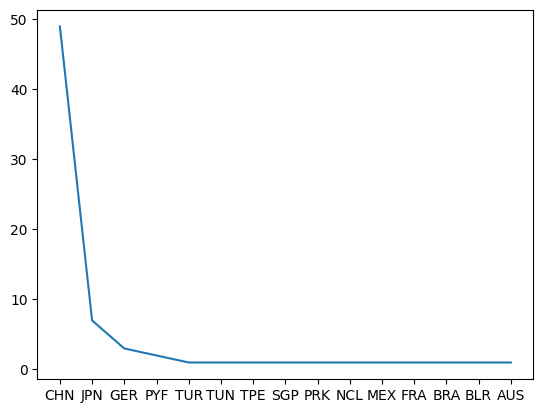

,Unnamed: 0,Player,Player ID,Assoc,Gender,Birth year,Activity,Playing hand,Playing style,Grip,Playing_hand_numeric,Playing_style_numeric,Grip_numeric,Style_commonness,Win Rate
0,0,MA Long,105649,CHN,Male,1988.0,Active,Right-handed,Attacker,Shakehand,0,0,0,0,87.16
1,1,CHUANG Chih-Yuan,101820,TPE,Male,1981.0,Active,Right-handed,Attacker,Shakehand,0,0,0,0,64.38
2,2,BOLL Timo,101222,GER,Male,1981.0,Active,Left-handed,Attacker,Shakehand,1,0,0,1,78.06
3,3,OVTCHAROV Dimitrij,107028,GER,Male,1988.0,Active,Right-handed,Attacker,Shakehand,0,0,0,0,71.41
4,4,FENG Tianwei,102712,SGP,Female,1986.0,Active,Right-handed,Attacker,Shakehand,0,0,0,0,71.05


In [68]:
dfwithwinrate=pd.read_csv('player_info_with_win_rate.csv')
dfwithwinrate.head()
pysqldf= lambda q:sqldf(q,globals())
#水平说得过去（即胜率>=40）的玩家，它们加入之后的假设检验
q=""" select * from dfwithwinrate df where df."Win Rate">=40 """
dfgood=pysqldf(q)
dfgood.head()

#水平好的协会（产生过胜率大于等于70的超一流运动员的协会，只要产生过一位即算）
qq="""select df.Assoc,count(df.Assoc) as number_powerful_players from dfwithwinrate df where df."Win Rate">=70 group by df.Assoc order by number_powerful_players desc"""
dfgood_assoc=pysqldf(qq)
print(dfgood_assoc)
plt.plot(dfgood_assoc["Assoc"],dfgood_assoc["number_powerful_players"])
plt.show()

#世界好的协会们的运动员们
qqq="""select * from dfwithwinrate df where df."Assoc" in (select dfgood_assoc.Assoc from dfgood_assoc)"""
dfgood_assoc_players=pysqldf(qqq)
dfgood_assoc_players.head()







In [103]:
# 对我们筛选过后的"强力协会的运动员们"做mca
#mca可以对各个样本（也就是每位运动员）也可以对各个变量
#我们从对每位运动员开始



cat_cols = [
    "Assoc","Gender","Activity","Playing hand",
    "Playing style","Grip","Style_commonness"
]
df_cat = dfgood_assoc_players[cat_cols].astype(str)
print("Cat DF shape:", df_cat.shape)
max_dims = min(df_cat.shape) - 1  # = 6
# 3. 初始化并拟合 MCA
mca = prince.MCA(
    n_components=max_dims,
    n_iter=10,
    random_state=42
)
mca2 = mca.fit(df_cat)
row_coords = mca2.row_coordinates(df_cat)
print("Row coords shape:", row_coords.shape)

inertia_ratios = mca2.eigenvalues_  # [0.35, 0.15, 0.10, …]
print(inertia_ratios)


# 4. 合并 Player & Win Rate
# 方法 A：reset_index + concat
coords = row_coords.reset_index(drop=True)
meta   = dfgood_assoc_players[["Player","Win Rate"]].reset_index(drop=True)
result = pd.concat([coords, meta], axis=1)

print(result.head())


# 假设 result 已经准备好：
# result.columns == [0, 1, 'Player', 'Win Rate']

# fig, ax = plt.subplots(figsize=(10, 8))

# # 散点：x=第一主成分, y=第二主成分, 大小∝胜率
# scatter = ax.scatter(
#     result[0],               # 第一主成分
#     result[1],               # 第二主成分
#     s = result["Win Rate"],  # 点面积映射胜率
#     alpha = 0.6
# )

import plotly.express as px

fig = px.scatter(
    result,
    x=0, y=1,
    size="Win Rate",               # 点面积映射胜率
    color="Win Rate",              # 点颜色映射胜率
    hover_name="Player",           # 悬停时显示选手名
    labels={0: f"Dim 1 ({explained_ratio[0]*100:.1f}%)",
            1: f"Dim 2 ({explained_ratio[1]*100:.1f}%)"},
    title="MCA – Win Rate 映射点色 & 大小"
)
fig.update_layout(template="simple_white")
fig.show()

# # 标注每个点的选手名字
# for i, name in enumerate(result["Player"]):
#     ax.annotate(
#         name,
#         (result.iloc[i, 0], result.iloc[i, 1]),
#         fontsize=6,
#         xytext=(2, 2),
#         textcoords='offset points'
#     )

# 坐标轴和标题
# ax.set_xlabel("Dimension 1")
# ax.set_ylabel("Dimension 2")
# ax.set_title("MCA Scatter Plot – point_surface ∝ Win Rate")

# plt.tight_layout()
# plt.show()

Cat DF shape: (287, 7)
Row coords shape: (287, 6)
[0.28371439 0.23041834 0.19395558 0.16777755 0.15584412 0.14296763]
          0         1         2         3         4         5  \
0 -0.298858 -0.270632  0.000079 -0.399231  0.109149 -0.030778   
1 -0.331241 -0.263561 -0.126266 -0.044018 -0.023584 -0.356957   
2  0.739197 -0.263657 -0.135971  0.464010  0.206202 -0.100363   
3 -0.311654 -0.082882 -0.067674  0.132267  0.319541 -0.099842   
4 -0.481565  0.293914 -0.177464 -0.022274 -1.326130 -0.012014   

               Player  Win Rate  
0             MA Long     87.16  
1    CHUANG Chih-Yuan     64.38  
2           BOLL Timo     78.06  
3  OVTCHAROV Dimitrij     71.41  
4        FENG Tianwei     71.05  


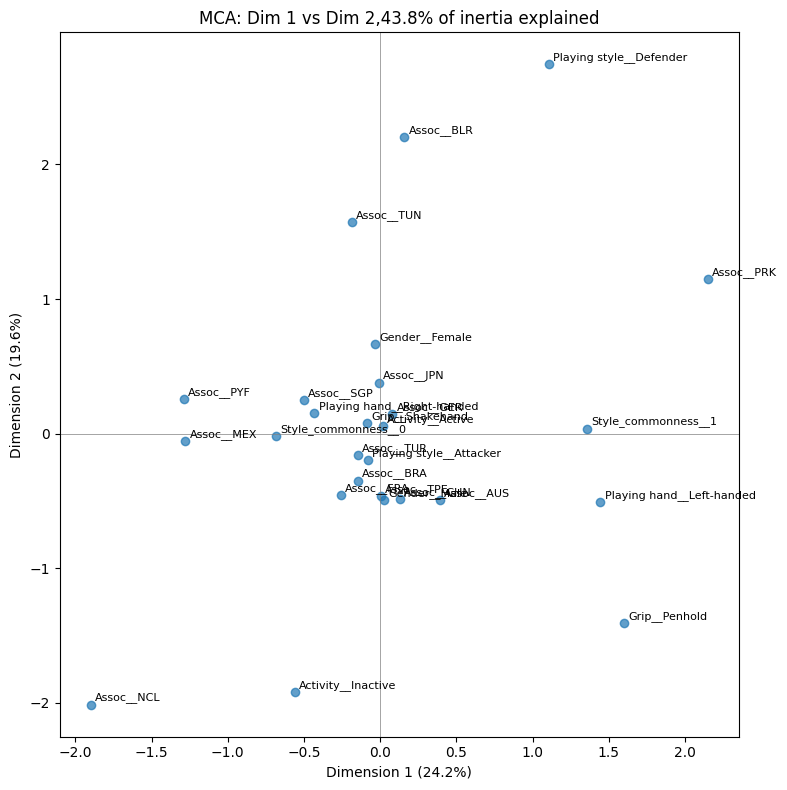

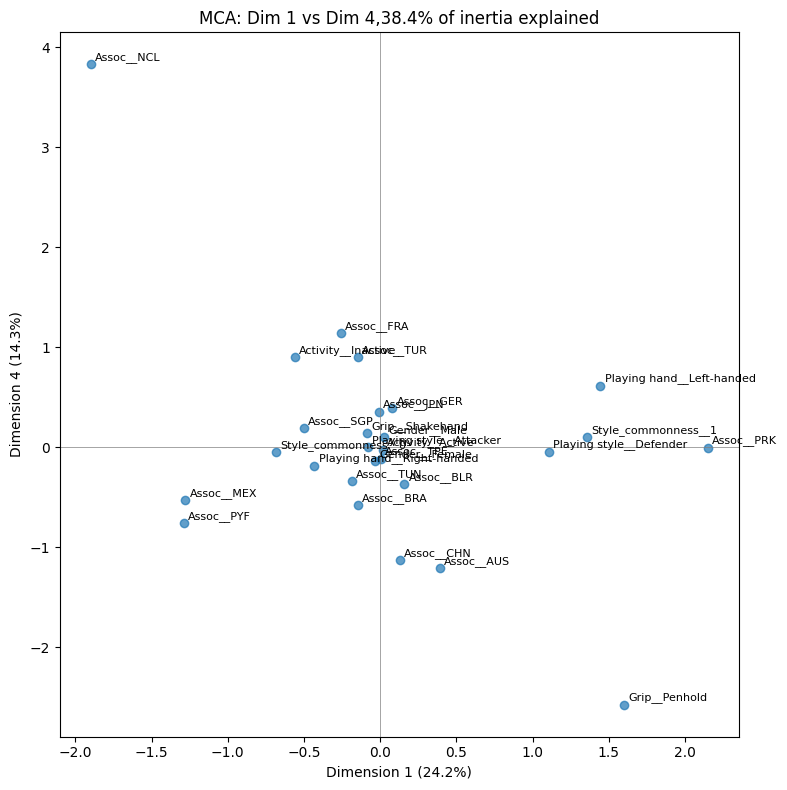

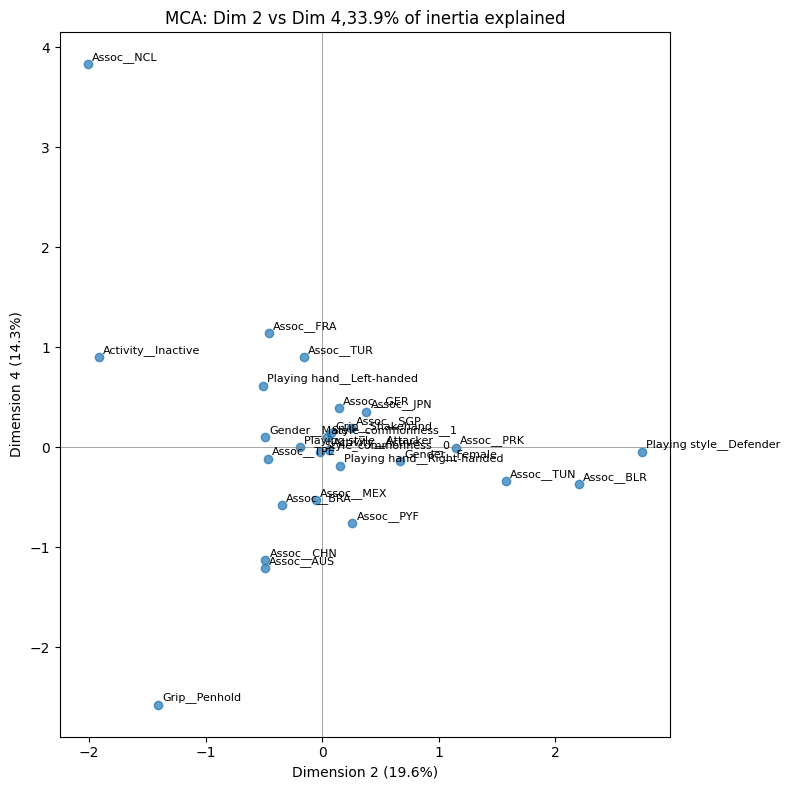

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# 取出列坐标和特征值
col_coords = mca2.column_coordinates(df_cat)
eig = np.array(mca2.eigenvalues_)
explained_ratio = eig / eig.sum()

def plot_plane(dim_x, dim_y):
    fig, ax = plt.subplots(figsize=(8, 8))
    # 散点
    ax.scatter(col_coords[dim_x], col_coords[dim_y], alpha=0.7)
    # 标注
    for label, x, y in zip(col_coords.index, col_coords[dim_x], col_coords[dim_y]):
        if isinstance(label, tuple):
            text = f"{label[0]}={label[1]}" if len(label) > 1 else str(label)
        else:
            text = str(label)
        ax.annotate(text, (x, y),
                    fontsize=8, xytext=(3, 3), textcoords='offset points')
    # 参考线
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    # 轴标签带解释率
    ax.set_xlabel(f"Dimension {dim_x+1} ({explained_ratio[dim_x]*100:.1f}%)")
    ax.set_ylabel(f"Dimension {dim_y+1} ({explained_ratio[dim_y]*100:.1f}%)")
    ax.set_title(f"MCA: Dim {dim_x+1} vs Dim {dim_y+1},{explained_ratio[dim_x]*100+explained_ratio[dim_y]*100:.1f}% of inertia explained")
    plt.tight_layout()
    plt.show()

#######some interpretation of MCA results########



# 1 vs 2
plot_plane(0, 1)
# left hand correlated with penhold # assoc blr has more defenders（most famous samsonov）

# 1 vs 3
plot_plane(0, 3)
# most french powerful tt players has retired
#assoc north korea has higher diversity of playing style

# 2 vs 4
plot_plane(1, 3)
# assoc china has more penhold players





# Part Test

In [116]:
q2 = """select * from dfgood df where cast(substr(df."Birth year",1,instr(df."Birth year",'.')-1) as integer) between 1960 and 1980"""
dfg_before=pysqldf(q2)
print(dfg_before.shape)
dfg_before.head()

q21= """select count(*) as total_effectif, sum(df.Style_commonness)*1.0/count(*) as avg_style_diversity_before from dfg_before df"""
dfg_diversity_before=pysqldf(q21)
print(dfg_diversity_before)

q22="""select df.Style_commonness as style from dfg_before df"""
dfg_style_before=pysqldf(q22)
print(dfg_style_before.head())

q3 = """select * from dfgood df where cast(substr(df."Birth year",1,instr(df."Birth year",'.')-1) as integer) >=1981"""
dfg_after=pysqldf(q3)
print(dfg_after.shape)
dfg_after.head()

q31= """select count(*) as total_effectif, sum(df.Style_commonness)*1.0/count(*) as avg_style_diversity_after from dfg_after df"""
dfg_diversity_after=pysqldf(q31)
print(dfg_diversity_after)

q32="""select df.Style_commonness as style from dfg_after df"""
dfg_style_after=pysqldf(q32)
print(dfg_style_after.head())



(91, 15)
   total_effectif  avg_style_diversity_before
0              91                    0.384615
   style
0      0
1      1
2      0
3      0
4      0
(706, 15)
   total_effectif  avg_style_diversity_after
0             706                   0.288952
   style
0      0
1      0
2      1
3      0
4      0


In [118]:
#hyp preliminaire： les variances sont egaux
# Notre hyp0: diversite before<=diversite after
# Notre hyp1: diversite before>=diversite after

styles_before=dfg_style_before.to_numpy().ravel()
styles_after=dfg_style_after.to_numpy().ravel()

t_stat,p_val_two_tail=stats.ttest_ind(styles_before,styles_after,equal_var=True)
t_stat2,p_val_two_tail2=stats.ttest_ind(styles_before,styles_after,equal_var=False)
p_one_tail=p_val_two_tail/2
p_one_tail2=p_val_two_tail2/2
print(f"t = {t_stat:.3f}, p-t-test = {p_one_tail:.3f},p-welch-test = {p_one_tail2:.3f}")

# en tout cas, p<<0.05 donc on peut rejeter hyp 0,oui il y a une degradation de diversite pongiste avant et apres lannee 2000


t = 1.876, p-t-test = 0.030,p-welch-test = 0.040


# Partie ML--- XGboost

In [156]:
#etape1 把我们要用来ml的部分扒拉出来（即除了名字，运动员id以及最终标签胜率的所有列）

dfwithwinrate=pd.read_csv('player_info_with_win_rate.csv')
cols = list(range(3, 10)) + [-2]    # 3,4,5,6,7,8,9, 和 最后一列
datapourml=dfwithwinrate.iloc[:,cols].copy()
datapourml["Birth year"]=datapourml["Birth year"].astype(int)
datapourml["Playing hand"]=datapourml["Playing hand"].astype('category')
datapourml["Assoc"]=datapourml["Assoc"].astype('category')
datapourml["Gender"]=datapourml["Gender"].astype('category')
datapourml["Activity"]=datapourml["Activity"].astype('category')
datapourml["Playing style"]=datapourml["Playing style"].astype('category')
datapourml["Grip"]=datapourml["Grip"].astype('category')
datapourml["Style_commonness"]=datapourml["Style_commonness"].astype('category')

# datapourml["Style_commonness"]=datapourml["Style_commonness"].astype('category')
print(datapourml.head())
X=datapourml
y=dfwithwinrate["Win Rate"]
print(X.shape)
print(y.shape)


Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=42)
print(Xtrain.shape)
print(Xtest.shape)

Xtrain,Xvalid,ytrain,yvalid=train_test_split(Xtrain,ytrain,test_size=0.2,random_state=42)
print("train shape",Xtrain.shape)
print("valid shape",Xvalid.shape)
print("test shape",Xtest.shape)

dtrain=xgb.DMatrix(Xtrain,label=ytrain,enable_categorical=True)
dvalid=xgb.DMatrix(Xvalid,label=yvalid,enable_categorical=True)
dtest=xgb.DMatrix(Xtest,label=ytest,enable_categorical=True)
params={
    'objective':'reg:squarederror',
    'tree_method':'hist',
    'eval_metric':'rmse'
}
evals_result = {}
bestmodel=xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain,'train'),(dvalid,'valid')],
    evals_result=evals_result,
    verbose_eval=10,
    early_stopping_rounds=3
)

y_pred = bestmodel.predict(dtest)


  Assoc  Gender  Birth year Activity  Playing hand Playing style       Grip  \
0   CHN    Male        1988   Active  Right-handed      Attacker  Shakehand   
1   TPE    Male        1981   Active  Right-handed      Attacker  Shakehand   
2   GER    Male        1981   Active   Left-handed      Attacker  Shakehand   
3   GER    Male        1988   Active  Right-handed      Attacker  Shakehand   
4   SGP  Female        1986   Active  Right-handed      Attacker  Shakehand   

  Style_commonness  
0                0  
1                0  
2                1  
3                0  
4                0  
(820, 8)
(820,)
(656, 8)
(164, 8)
train shape (524, 8)
valid shape (132, 8)
test shape (164, 8)
[0]	train-rmse:7.57560	valid-rmse:7.82019
[6]	train-rmse:3.93918	valid-rmse:7.16780


{'train': OrderedDict([('rmse', [7.575596545241781, 6.302596295375244, 5.40934879165845, 4.800470109735329, 4.379042088060239, 4.090749559818913, 3.9391761079395518])]), 'valid': OrderedDict([('rmse', [7.820185211014931, 7.276564451416697, 7.020002300249642, 7.015513606946407, 7.067103501038818, 7.139265530177115, 7.167802394990021])])}


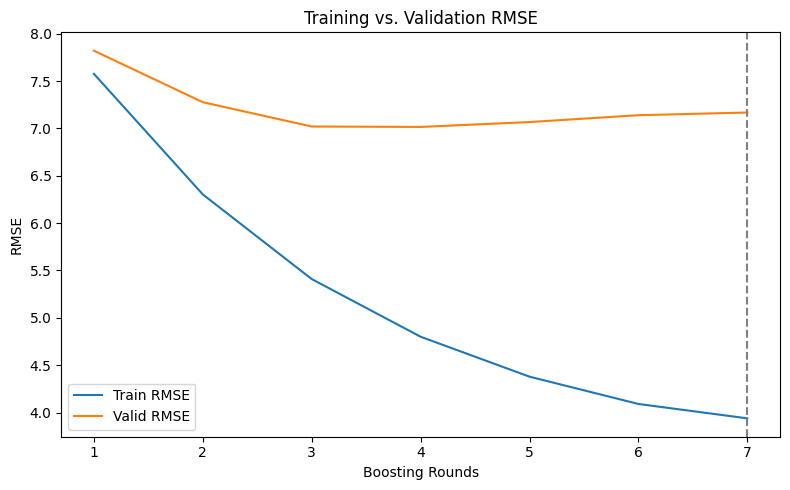

In [157]:
# bestmodel 是你用 xgb.train 训练出来的 Booster

print(evals_result)

train_rmse = evals_result['train']['rmse']
valid_rmse = evals_result['valid']['rmse']
epochs     = range(1, len(train_rmse) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, label='Train RMSE')
plt.plot(epochs, valid_rmse, label='Valid RMSE')
plt.axvline(len(valid_rmse), color='gray', linestyle='--')  # 最佳轮次附近
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training vs. Validation RMSE')
plt.legend()
plt.tight_layout()
plt.show()


In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# RMSE
rmse = mean_squared_error(ytest, y_pred)
# MAE
mae  = mean_absolute_error(ytest, y_pred)
# R²
r2   = r2_score(ytest, y_pred)

print(f"Test RMSE = {rmse:.3f}")
print(f"Test MAE  = {mae:.3f}")
print(f"Test R²   = {r2:.3f}")

Test RMSE = 52.399
Test MAE  = 5.332
Test R²   = 0.467


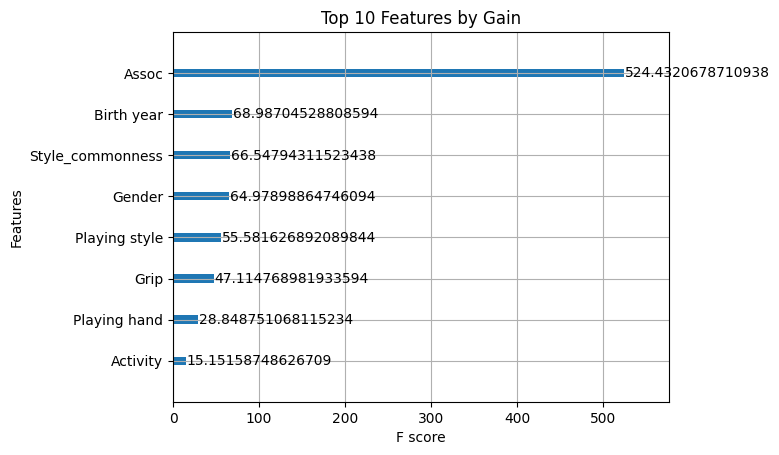

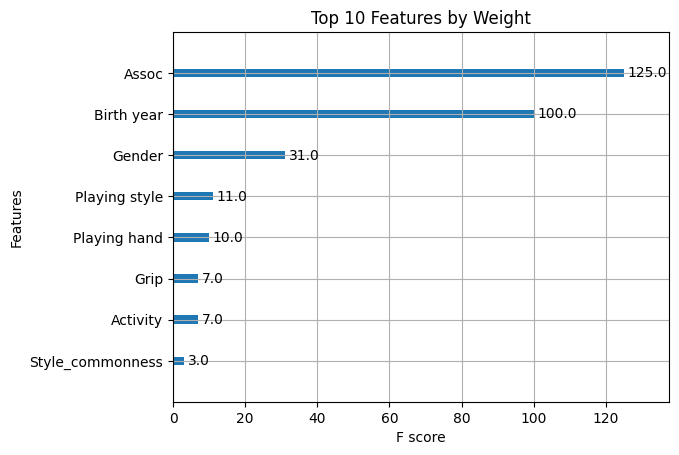

In [159]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 方法 A：基于 gain
xgb.plot_importance(bestmodel, importance_type='gain', max_num_features=10)
plt.title('Top 10 Features by Gain')
plt.show()

# 方法 B：基于 weight（出现次数）
xgb.plot_importance(bestmodel, importance_type='weight', max_num_features=10)
plt.title('Top 10 Features by Weight')
plt.show()
